<a href="https://colab.research.google.com/github/balajibvns442/Final_Year_Project/blob/basics/CNN_models/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# STEP 1: Setup & Imports
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ============================================
# STEP 2: Data Preprocessing
# ============================================
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # resize all images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])

train_data = datasets.ImageFolder("/content/drive/MyDrive/Dataset-2/train", transform=transform)
val_data   = datasets.ImageFolder("/content/drive/MyDrive/Dataset-2/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)  # should print ['cancer', 'noncancer']

Classes: ['cancer', 'non-cancer']


In [ ]:
# ============================================
# STEP 3: Define CNN Model
# ============================================
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # depends on input size (64x64)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: cancer / noncancer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = x.view(-1, 64 * 16 * 16)          # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # Output layer
        return x

model = CancerCNN().to(device)
print(model)

CancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
# ============================================
# STEP 4: Training Setup
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================================
# STEP 5: Training Loop
# ============================================
EPOCHS = 5
train_losses, val_losses, val_acc = [], [], []
train_acc = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    acc_train = 100 * correct_train / total_train
    train_acc.append(acc_train)


    # Validation
    model.eval()
    correct_val, total_val, vloss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            vloss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_losses.append(vloss/len(val_loader))
    acc_val = 100 * correct_val / total_val
    val_acc.append(acc_val)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_acc[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {acc_val:.2f}%")

Epoch 1/5, Train Loss: 0.2237, Train Acc: 90.66%, Val Loss: 0.4314, Val Acc: 81.47%
Epoch 2/5, Train Loss: 0.1611, Train Acc: 93.90%, Val Loss: 0.5170, Val Acc: 80.60%
Epoch 3/5, Train Loss: 0.1231, Train Acc: 95.58%, Val Loss: 0.4167, Val Acc: 83.62%
Epoch 4/5, Train Loss: 0.0934, Train Acc: 96.95%, Val Loss: 0.4397, Val Acc: 84.48%
Epoch 5/5, Train Loss: 0.0712, Train Acc: 97.54%, Val Loss: 0.4778, Val Acc: 81.90%


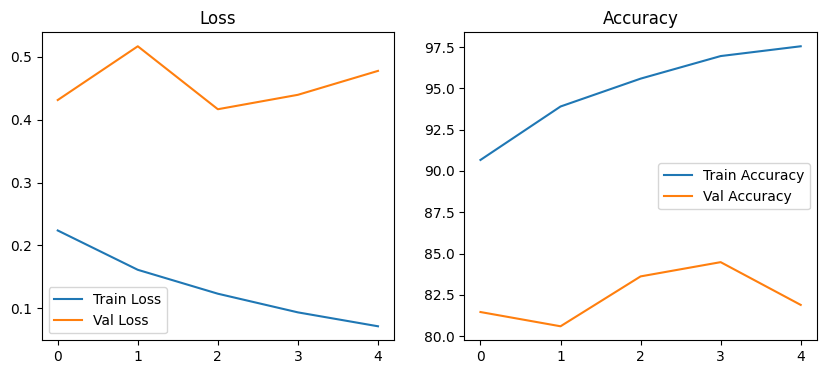

In [ ]:
# ============================================
# STEP 6: Plot Results
# ============================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [ ]:
# ============================================
# STEP 7: Save Model
# ============================================
torch.save(model.state_dict(), "cancer_cnn.pth")
print("Model saved as cancer_cnn.pth")

Model saved as cancer_cnn.pth


In [ ]:
from PIL import Image

# Load trained model
model = CancerCNN().to(device)
model.load_state_dict(torch.load("cancer_cnn.pth", map_location=device))
model.eval()

CancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
    return train_data.classes[predicted.item()]

# Example test
print(predict_image("/content/drive/MyDrive/Dataset-2/train/non-cancer/image_0001.jpg"))

non-cancer
